In [1]:
import pickle
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest,f_classif
from sklearn.decomposition import PCA
from pprint import pprint
from sklearn.metrics import f1_score,r2_score,classification_report,roc_auc_score
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,RandomForestRegressor
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix,f1_score,precision_score,recall_score,accuracy_score
import itertools
from sklearn.model_selection import ParameterGrid, cross_val_predict, GroupKFold,GridSearchCV,StratifiedKFold
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
from joblib import Parallel,delayed

def svar(X):
    n = float(len(X))
    svar=(sum([(x-np.mean(X))**2 for x in X]) / n)* n/(n-1.)
    return svar

def CronbachAlpha(itemscores):
    itemvars = [svar(item) for item in itemscores]
    tscores = [0] * len(itemscores[0])
    for item in itemscores:
        for i in range(len(item)):
            tscores[i]+= item[i]
    nitems = len(itemscores)
    Calpha=nitems/(nitems-1.) * (1-sum(itemvars)/ svar(tscores))
    return Calpha

from scipy.stats import iqr,skew,kurtosis,pearsonr
from scipy.stats import variation,moment

def get_features1(x):
    temp = []
    temp.append(x[-1])
    temp.append(x[0])
    temp.append(x[len(x)//2])
    temp.append(iqr(x))
    temp.append(skew(x))
    temp.append(kurtosis(x))
    temp.append(variation(x))
    temp.append(iqr(x[:len(x)//2]))
    temp.append(skew(x[:len(x)//2]))
    temp.append(kurtosis(x[:len(x)//2]))
    temp.append(variation(x[:len(x)//2]))
    temp.append(iqr(x[len(x)//2:]))
    temp.append(skew(x[len(x)//2:]))
    temp.append(kurtosis(x[len(x)//2:]))
    temp.append(variation(x[len(x)//2:]))
    return np.array(temp)

# def get_features()

def get_features(temp,user):
    if temp.shape[0]<10:
        return -1,-1,-1,-1,-1
    if temp['time'].values[-1]-temp['time'].values[0]>1000:
        return -1,-1,-1,-1,-1
#     if np.isnan(temp['score'].values[-1]):
#         return -1,-1,-1,-1,-1
    a = temp['stress_likelihood'].values
    b = temp['all_scores'].values[-1]
    c = user
    hour = datetime.fromtimestamp(temp['time'].values[0]).hour
    if hour<8:
        d = 0
    elif hour>8 and hour < 16:
        d = 1
    else:
        d = 2
    e = user+temp['day'].values[-1]
    return a,b,c,d,e

def get_user_data(user_data,user):
    X_date = []
    X = []
    y = []
    groups = []
    days = []
    if len(np.unique(user_data.dropna()['day'].values))<4:
        return [],[],[],[],[]
    user_data = user_data.sort_values('localtime').reset_index(drop=True)
    count = 0
    columns=['window', 'localtime', 'day', 'stress_likelihood', 'imputed',
       'likelihood_mean', 'all_scores', 'score', 'label', 'version', 'user',
       'time']
    count = 0
    data = Parallel(n_jobs=20,verbose=1)(delayed(get_features)(user_data.loc[i:i+10],user) for i,row in user_data.iterrows())
#                                         if not np.isnan(user_data.loc[i:i+10]['score'].values[-1]))
    for a in data:
        if not isinstance(a[2], str):
            continue
        X.append(a[0])
        y.append(a[1])
        groups.append(a[2])
        X_date.append(a[3])
        days.append(a[4])
    return X,y,groups,X_date,days


def get_data(all_stress):
    X_date,X,y,groups,days = [],[],[],[],[]
    final = [get_user_data(all_stress[all_stress.user.isin([user])],user) 
                                          for user in np.unique(all_stress['user'].values)]
    for a in final:
        X.extend(a[0])
        y.extend(a[1])
        groups.extend(a[2])
        X_date.extend(a[3])
        days.extend(a[4])
    return X,y,groups,X_date,days

In [2]:
import warnings
import pickle
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler,OneHotEncoder
all_stress_left = pickle.load(open('../data/stress_ema_md2k_aa_rice_left_ppg.p','rb'))
# all_stress_left = all_stress_left[all_stress_left.imputed.isin([0])]
all_stress_right = pickle.load(open('../data/stress_ema_md2k_aa_rice_right1_ppg.p','rb'))
# all_stress_right = all_stress_right[all_stress_right.imputed.isin([0])]

In [7]:
X2,y2,groups2,X_date2,days2 = get_data(all_stress_left)
X3,y3,groups3,X_date3,days3 = get_data(all_stress_right)
Xf,yf,groupsf,X_datef,daysf = X2+X3,y2+y3,groups2+groups3,X_date2+X_date3,days2+days3

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    1.1s
[Parallel(n_jobs=20)]: Done 240 tasks      | elapsed:    2.1s
[Parallel(n_jobs=20)]: Done 740 tasks      | elapsed:    3.8s
[Parallel(n_jobs=20)]: Done 1440 tasks      | elapsed:    6.1s
[Parallel(n_jobs=20)]: Done 2340 tasks      | elapsed:    9.1s
[Parallel(n_jobs=20)]: Done 4520 tasks      | elapsed:   14.7s
[Parallel(n_jobs=20)]: Done 7120 tasks      | elapsed:   20.9s
[Parallel(n_jobs=20)]: Done 8178 out of 8178 | elapsed:   23.2s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 280 tasks      | elapsed:    1.3s
[Parallel(n_jobs=20)]: Done 780 tasks      | elapsed:    3.0s
[Parallel(n_jobs=20)]: Done 1480 tasks      | elapsed:    5.3s
[Parallel(n_jobs=20)]: Done 3080 tasks      | elapsed:    9.8s
[Parallel(n_jobs=20)]: 

[Parallel(n_jobs=20)]: Done 1480 tasks      | elapsed:    5.5s
[Parallel(n_jobs=20)]: Done 2380 tasks      | elapsed:    8.5s
[Parallel(n_jobs=20)]: Done 3480 tasks      | elapsed:   12.2s
[Parallel(n_jobs=20)]: Done 4780 tasks      | elapsed:   16.9s
[Parallel(n_jobs=20)]: Done 7520 tasks      | elapsed:   24.2s
[Parallel(n_jobs=20)]: Done 8517 out of 8517 | elapsed:   26.5s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.3s
[Parallel(n_jobs=20)]: Done 280 tasks      | elapsed:    1.3s
[Parallel(n_jobs=20)]: Done 780 tasks      | elapsed:    3.1s
[Parallel(n_jobs=20)]: Done 2120 tasks      | elapsed:    6.4s
[Parallel(n_jobs=20)]: Done 3920 tasks      | elapsed:   10.6s
[Parallel(n_jobs=20)]: Done 6120 tasks      | elapsed:   15.9s
[Parallel(n_jobs=20)]: Done 8720 tasks      | elapsed:   22.4s
[Parallel(n_jobs=20)]: Done 11720 tasks      | elapsed:   29.8s
[Parallel(n_jobs=20)]: Done 15120

[Parallel(n_jobs=20)]: Done 9880 tasks      | elapsed:   34.0s
[Parallel(n_jobs=20)]: Done 11980 tasks      | elapsed:   41.1s
[Parallel(n_jobs=20)]: Done 14280 tasks      | elapsed:   48.8s
[Parallel(n_jobs=20)]: Done 16780 tasks      | elapsed:   57.0s
[Parallel(n_jobs=20)]: Done 19720 tasks      | elapsed:  1.1min
[Parallel(n_jobs=20)]: Done 20072 out of 20072 | elapsed:  1.1min finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.3s
[Parallel(n_jobs=20)]: Done 280 tasks      | elapsed:    1.3s
[Parallel(n_jobs=20)]: Done 780 tasks      | elapsed:    3.0s
[Parallel(n_jobs=20)]: Done 1720 tasks      | elapsed:    5.9s
[Parallel(n_jobs=20)]: Done 3520 tasks      | elapsed:   10.3s
[Parallel(n_jobs=20)]: Done 5720 tasks      | elapsed:   15.6s
[Parallel(n_jobs=20)]: Done 8320 tasks      | elapsed:   22.1s
[Parallel(n_jobs=20)]: Done 11320 tasks      | elapsed:   29.6s
[Parallel(n_jobs=20)]: Done

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 400 tasks      | elapsed:    1.1s
[Parallel(n_jobs=20)]: Done 1400 tasks      | elapsed:    2.8s
[Parallel(n_jobs=20)]: Done 2800 tasks      | elapsed:    5.1s
[Parallel(n_jobs=20)]: Done 4600 tasks      | elapsed:    8.3s
[Parallel(n_jobs=20)]: Done 6800 tasks      | elapsed:   11.8s
[Parallel(n_jobs=20)]: Done 9400 tasks      | elapsed:   16.1s
[Parallel(n_jobs=20)]: Done 12400 tasks      | elapsed:   20.9s
[Parallel(n_jobs=20)]: Done 15800 tasks      | elapsed:   26.7s
[Parallel(n_jobs=20)]: Done 18978 out of 18978 | elapsed:   31.9s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 440 tasks      | elapsed:    1.1s
[Parallel(n_jobs=20)]: Done 1440 tasks      | elapsed:    2.7s
[Parallel(n_jobs=20)]: Done 3080 tasks      | elapsed:    5.2s
[Parallel(n_jobs=20)]: Done 619

[Parallel(n_jobs=20)]: Done 2840 tasks      | elapsed:    5.3s
[Parallel(n_jobs=20)]: Done 4640 tasks      | elapsed:    8.2s
[Parallel(n_jobs=20)]: Done 6840 tasks      | elapsed:   11.9s
[Parallel(n_jobs=20)]: Done 8389 out of 8389 | elapsed:   14.2s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 440 tasks      | elapsed:    1.1s
[Parallel(n_jobs=20)]: Done 1440 tasks      | elapsed:    2.8s
[Parallel(n_jobs=20)]: Done 2840 tasks      | elapsed:    4.9s
[Parallel(n_jobs=20)]: Done 4640 tasks      | elapsed:    8.0s
[Parallel(n_jobs=20)]: Done 6840 tasks      | elapsed:   11.6s
[Parallel(n_jobs=20)]: Done 9800 tasks      | elapsed:   16.3s
[Parallel(n_jobs=20)]: Done 15800 tasks      | elapsed:   24.8s
[Parallel(n_jobs=20)]: Done 17697 out of 17697 | elapsed:   27.3s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Paral

[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    1.4s
[Parallel(n_jobs=20)]: Done 2600 tasks      | elapsed:    4.1s
[Parallel(n_jobs=20)]: Done 5400 tasks      | elapsed:    8.0s
[Parallel(n_jobs=20)]: Done 7753 out of 7753 | elapsed:   11.1s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 440 tasks      | elapsed:    1.0s
[Parallel(n_jobs=20)]: Done 1440 tasks      | elapsed:    2.6s
[Parallel(n_jobs=20)]: Done 2840 tasks      | elapsed:    4.9s
[Parallel(n_jobs=20)]: Done 4640 tasks      | elapsed:    7.9s
[Parallel(n_jobs=20)]: Done 6840 tasks      | elapsed:   11.9s
[Parallel(n_jobs=20)]: Done 9440 tasks      | elapsed:   16.4s
[Parallel(n_jobs=20)]: Done 14920 tasks      | elapsed:   23.9s
[Parallel(n_jobs=20)]: Done 16306 out of 16306 | elapsed:   25.6s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parall

[Parallel(n_jobs=20)]: Done 4640 tasks      | elapsed:    8.2s
[Parallel(n_jobs=20)]: Done 6840 tasks      | elapsed:   11.7s
[Parallel(n_jobs=20)]: Done 9440 tasks      | elapsed:   16.2s
[Parallel(n_jobs=20)]: Done 13320 tasks      | elapsed:   22.3s
[Parallel(n_jobs=20)]: Done 14166 out of 14166 | elapsed:   23.2s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 440 tasks      | elapsed:    1.0s
[Parallel(n_jobs=20)]: Done 1440 tasks      | elapsed:    2.8s
[Parallel(n_jobs=20)]: Done 2840 tasks      | elapsed:    5.2s
[Parallel(n_jobs=20)]: Done 4640 tasks      | elapsed:    8.3s
[Parallel(n_jobs=20)]: Done 6840 tasks      | elapsed:   11.7s
[Parallel(n_jobs=20)]: Done 11720 tasks      | elapsed:   18.6s
[Parallel(n_jobs=20)]: Done 17720 tasks      | elapsed:   26.5s
[Parallel(n_jobs=20)]: Done 19316 out of 19316 | elapsed:   28.6s finished
[Parallel(n_jobs

[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 440 tasks      | elapsed:    1.1s
[Parallel(n_jobs=20)]: Done 1440 tasks      | elapsed:    3.0s
[Parallel(n_jobs=20)]: Done 2840 tasks      | elapsed:    5.4s
[Parallel(n_jobs=20)]: Done 4640 tasks      | elapsed:    8.4s
[Parallel(n_jobs=20)]: Done 6840 tasks      | elapsed:   12.0s
[Parallel(n_jobs=20)]: Done 11320 tasks      | elapsed:   18.5s
[Parallel(n_jobs=20)]: Done 17320 tasks      | elapsed:   27.0s
[Parallel(n_jobs=20)]: Done 20095 out of 20095 | elapsed:   30.5s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 440 tasks      | elapsed:    1.0s
[Parallel(n_jobs=20)]: Done 1440 tasks      | elapsed:    2.7s
[Parallel(n_jobs=20)]: Done 2840 tasks      | elapsed:    5.1s
[Parallel(n_jobs=20)]: Done 5320 tasks      | elapsed:    8.9s
[Parallel(n_jobs=20)]: Done 972

[Parallel(n_jobs=20)]: Done 11666 out of 11666 | elapsed:   16.2s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 440 tasks      | elapsed:    1.0s
[Parallel(n_jobs=20)]: Done 1440 tasks      | elapsed:    2.8s
[Parallel(n_jobs=20)]: Done 2840 tasks      | elapsed:    5.2s
[Parallel(n_jobs=20)]: Done 4680 tasks      | elapsed:    8.3s
[Parallel(n_jobs=20)]: Done 7604 out of 7604 | elapsed:   12.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 400 tasks      | elapsed:    1.2s
[Parallel(n_jobs=20)]: Done 1400 tasks      | elapsed:    2.9s
[Parallel(n_jobs=20)]: Done 2800 tasks      | elapsed:    5.2s
[Parallel(n_jobs=20)]: Done 5280 tasks      | elapsed:    9.1s
[Parallel(n_jobs=20)]: Done 9680 tasks      | elapsed:   15.2s
[Parallel

[Parallel(n_jobs=20)]: Done 7800 tasks      | elapsed:   11.4s
[Parallel(n_jobs=20)]: Done 12200 tasks      | elapsed:   17.4s
[Parallel(n_jobs=20)]: Done 17400 tasks      | elapsed:   24.1s
[Parallel(n_jobs=20)]: Done 17527 out of 17527 | elapsed:   24.2s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    1.2s
[Parallel(n_jobs=20)]: Done 2600 tasks      | elapsed:    3.9s
[Parallel(n_jobs=20)]: Done 5400 tasks      | elapsed:    7.7s
[Parallel(n_jobs=20)]: Done 9000 tasks      | elapsed:   12.5s
[Parallel(n_jobs=20)]: Done 13400 tasks      | elapsed:   18.6s
[Parallel(n_jobs=20)]: Done 18600 tasks      | elapsed:   25.7s
[Parallel(n_jobs=20)]: Done 18816 out of 18855 | elapsed:   25.7s remaining:    0.1s
[Parallel(n_jobs=20)]: Done 18855 out of 18855 | elapsed:   25.7s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20

In [8]:
pickle.dump([Xf,yf,groupsf,X_datef,daysf],open('../data/semi_supervised_no_imputation_autoencoder.p','wb'))

In [2]:
from sklearn import linear_model
Xf,yf,groupsf,X_datef,daysf = pickle.load(open('../data/semi_supervised_no_imputation_autoencoder.p','rb'))

In [4]:
from sklearn.preprocessing import StandardScaler,OneHotEncoder
X,y1,groups1,X_date_final = np.array(Xf),np.array(yf),np.array(groupsf),OneHotEncoder().fit_transform(np.array(X_datef).reshape(-1,1))
Xfeatures = np.array(Parallel(n_jobs=30,verbose=1)(delayed(get_features1)(x) for x in Xf))

/home/azim/.local/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done 166 tasks      | elapsed:    1.4s
[Parallel(n_jobs=30)]: Done 2880 tasks      | elapsed:    2.1s
[Parallel(n_jobs=30)]: Done 24320 tasks      | elapsed:    4.3s
[Parallel(n_jobs=30)]: Done 53120 tasks      | elapsed:    7.4s
[Parallel(n_jobs=30)]: Done 88320 tasks      | elapsed:   10.9s
[Parallel(n_jobs=30

In [15]:
from sklearn.model_selection import train_test_split,ParameterGrid
from frameworks.SelfLearning import SelfLearningModel
from frameworks.CPLELearning import CPLELearningModel
all_y = []
all_y_pred = []
all_groups = []
def get_labels(y):
    temp = np.array([np.mean(a) for a in y])
    temp_mean = np.mean(temp)
    index2 = np.where(temp>temp_mean)[0]
    index1 = np.where(temp<=temp_mean)[0]
    temp[index2] = 1
    temp[index1] = 0
    labels = temp
    labels = np.int64(np.array(labels))
    return labels
def get_model_performance(X_train,y_train,X_test,y_test,params):
    clf = LogisticRegression(**params)
#     clf = SVC(**params)
#     clf = RandomForestClassifier(**params)
#     clf = SelfLearningModel(clf)
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test[y_test>-1])
    y_test = y_test[y_test>-1]
    print(np.array([f1_score(y_test,y_pred),roc_auc_score(y_test,y_pred)]))
    return np.array([roc_auc_score(y_test,y_pred),
                     precision_score(y_test,y_pred),
                     recall_score(y_test,y_pred),
                     f1_score(y_test,y_pred)])
    
all_results = []
for user in np.unique(groups1):
    index = np.where(groups1==user)[0]
    X1,y,groups = Xfeatures[index],y1[index],groups1[index]
    index_not_nan = y!=None 
    X_nn,y_nn,groups_nn = X1[index_not_nan],y[index_not_nan],groups[index_not_nan]
    X_n,y_n,groups_n = X1[~index_not_nan],y[~index_not_nan],groups[~index_not_nan]
    y_nn = np.array(get_labels(y_nn))
    if len(np.unique(y_nn))<2:
        continue
    if len(y_nn[y_nn==1])<3:
        continue
    if len(y_nn[y_nn==0])<3:
        continue
    y_n = [-1]*len(y_n)
    X1 = np.concatenate([X_nn,X_n],axis=0)
    labels = np.array(list(y_nn)+y_n)
    print(X1.shape,X_n.shape,X_nn.shape,labels.shape)
    X_train, X_test, y_train, y_test = train_test_split(X1, labels, test_size=0.4, random_state=4,stratify=labels)
    paramGrid = ParameterGrid({
            'C': np.logspace(-3,3,10),
            'class_weight':[{0:1,1:4/2},{0:1,1:3/2},{0:1,1:5/2},{0:1,1:1}],
#             'probability':[True]
    })
    result = np.array(Parallel(n_jobs=30,verbose=1)(delayed(get_model_performance)(X_train[y_train>-1],
                                                                                   y_train[y_train>-1],
                                                                                  X_test,y_test,params) for params in paramGrid))
    if len(result[result[:,0]>=.5])>0:
        result = result[result[:,0]>=.5]
        all_results.append(result[np.argmax(result[:,-1])])
    else:
        all_results.append(result[np.argmax(result[:,-1])])
    print(result[np.argmax(result[:,1])])


(15803, 15) (15783, 15) (20, 15) (15803,)
[0.625      0.66666667 0.5        0.57142857]
(29522, 15) (29455, 15) (67, 15) (29522,)


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done  22 out of  40 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.


[0.55       1.         0.1        0.18181818]
(21628, 15) (21569, 15) (59, 15) (21628,)


[Parallel(n_jobs=30)]: Done  22 out of  40 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done  22 out of  40 | elapsed:    0.1s remaining:    0.1s


[0.65625    0.57142857 0.5        0.53333333]
(15197, 15) (15173, 15) (24, 15) (15197,)
[0.75       1.         0.5        0.66666667]


[Parallel(n_jobs=30)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done  22 out of  40 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  40 out of  40 | elapsed:    0.1s finished


(12010, 15) (11992, 15) (18, 15) (12010,)
[1. 1. 1. 1.]
(19769, 15) (19726, 15) (43, 15) (19769,)


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done  22 out of  40 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.


[0.65277778 0.6        0.75       0.66666667]
(18188, 15) (18165, 15) (23, 15) (18188,)


[Parallel(n_jobs=30)]: Done  22 out of  40 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.


[0.35714286 0.         0.         0.        ]
(35507, 15) (35425, 15) (82, 15) (35507,)


[Parallel(n_jobs=30)]: Done  22 out of  40 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done  22 out of  40 | elapsed:    0.1s remaining:    0.1s


[0.54779412 0.57142857 0.47058824 0.51612903]
(22833, 15) (22818, 15) (15, 15) (22833,)
[0.5        0.5        0.66666667 0.57142857]


[Parallel(n_jobs=30)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done  22 out of  40 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  40 out of  40 | elapsed:    0.1s finished


(32907, 15) (32857, 15) (50, 15) (32907,)
[0.5 0.  0.  0. ]
(23332, 15) (23308, 15) (24, 15) (23332,)


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done  22 out of  40 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.


[0.5 0.  0.  0. ]
(30651, 15) (30614, 15) (37, 15) (30651,)


[Parallel(n_jobs=30)]: Done  22 out of  40 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.


[0.59821429 0.57142857 0.57142857 0.57142857]
(25571, 15) (25528, 15) (43, 15) (25571,)


[Parallel(n_jobs=30)]: Done  22 out of  40 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done  22 out of  40 | elapsed:    0.1s remaining:    0.1s


[0.65       0.5        1.         0.66666667]
(27637, 15) (27577, 15) (60, 15) (27637,)
[0.52797203 0.5        0.36363636 0.42105263]


[Parallel(n_jobs=30)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done  22 out of  40 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  40 out of  40 | elapsed:    0.1s finished


(38394, 15) (38350, 15) (44, 15) (38394,)


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.


[0.5125 0.5    0.125  0.2   ]
(21794, 15) (21747, 15) (47, 15) (21794,)


[Parallel(n_jobs=30)]: Done  22 out of  40 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=30)]: Done  40 out of  40 | elapsed:    0.3s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.


[0.71794872 0.83333333 0.76923077 0.8       ]
(14116, 15) (14086, 15) (30, 15) (14116,)


[Parallel(n_jobs=30)]: Done  22 out of  40 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  40 out of  40 | elapsed:    0.2s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.


[0.58333333 0.54545455 1.         0.70588235]
(23802, 15) (23758, 15) (44, 15) (23802,)


[Parallel(n_jobs=30)]: Done  22 out of  40 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done  22 out of  40 | elapsed:    0.1s remaining:    0.1s


[0.54166667 0.7        0.58333333 0.63636364]
(31465, 15) (31377, 15) (88, 15) (31465,)
[0.5 0.  0.  0. ]


[Parallel(n_jobs=30)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done  22 out of  40 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  40 out of  40 | elapsed:    0.1s finished


(36041, 15) (36007, 15) (34, 15) (36041,)
[0.5 0.  0.  0. ]
(38254, 15) (38197, 15) (57, 15) (38254,)


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done  22 out of  40 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.


[0.56153846 0.66666667 0.2        0.30769231]
(31537, 15) (31526, 15) (11, 15) (31537,)


[Parallel(n_jobs=30)]: Done  22 out of  40 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.


[0.75       1.         0.5        0.66666667]
(21823, 15) (21779, 15) (44, 15) (21823,)


[Parallel(n_jobs=30)]: Done  22 out of  40 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.


[0.53246753 0.63636364 0.63636364 0.63636364]
(28946, 15) (28906, 15) (40, 15) (28946,)


[Parallel(n_jobs=30)]: Done  22 out of  40 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done  22 out of  40 | elapsed:    0.1s remaining:    0.1s


[0.6 0.7 0.7 0.7]
(12370, 15) (12361, 15) (9, 15) (12370,)
[0.75       0.66666667 1.         0.8       ]


[Parallel(n_jobs=30)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done  22 out of  40 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  40 out of  40 | elapsed:    0.1s finished


(26285, 15) (26240, 15) (45, 15) (26285,)
[0.74615385 0.5        0.8        0.61538462]
(38020, 15) (37983, 15) (37, 15) (38020,)


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done  22 out of  40 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  40 out of  40 | elapsed:    0.1s finished


[0.61363636 0.4        0.5        0.44444444]
(30471, 15) (30428, 15) (43, 15) (30471,)


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done  22 out of  40 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.


[0.75       0.69230769 1.         0.81818182]
(8227, 15) (8220, 15) (7, 15) (8227,)


[Parallel(n_jobs=30)]: Done  22 out of  40 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done  22 out of  40 | elapsed:    0.1s remaining:    0.1s


[0.75       0.5        1.         0.66666667]
(37087, 15) (37061, 15) (26, 15) (37087,)
[0.73333333 0.8        0.66666667 0.72727273]


[Parallel(n_jobs=30)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done  22 out of  40 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  40 out of  40 | elapsed:    0.1s finished


(36188, 15) (36094, 15) (94, 15) (36188,)
[0.73684211 0.84615385 0.57894737 0.6875    ]
(25779, 15) (25735, 15) (44, 15) (25779,)


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done  22 out of  40 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.


[0.66666667 0.71428571 0.55555556 0.625     ]
(30425, 15) (30378, 15) (47, 15) (30425,)


[Parallel(n_jobs=30)]: Done  22 out of  40 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done  22 out of  40 | elapsed:    0.1s remaining:    0.1s


[0.66666667 1.         0.33333333 0.5       ]
(16783, 15) (16763, 15) (20, 15) (16783,)
[0.66666667 1.         0.33333333 0.5       ]


[Parallel(n_jobs=30)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done  22 out of  40 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  40 out of  40 | elapsed:    0.1s finished


(38399, 15) (38311, 15) (88, 15) (38399,)
[0.62828947 0.58823529 0.625      0.60606061]
(12419, 15) (12405, 15) (14, 15) (12419,)


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done  22 out of  40 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.


[0.375      0.6        0.75       0.66666667]
(34990, 15) (34966, 15) (24, 15) (34990,)


[Parallel(n_jobs=30)]: Done  22 out of  40 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done  22 out of  40 | elapsed:    0.1s remaining:    0.1s


[0.8125     0.4        1.         0.57142857]
(20787, 15) (20736, 15) (51, 15) (20787,)


[Parallel(n_jobs=30)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done  22 out of  40 | elapsed:    0.1s remaining:    0.1s


[0.7375 0.6    0.6    0.6   ]
(28302, 15) (28247, 15) (55, 15) (28302,)


[Parallel(n_jobs=30)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done  22 out of  40 | elapsed:    0.1s remaining:    0.1s


[0.625 1.    0.25  0.4  ]
(23317, 15) (23285, 15) (32, 15) (23317,)
[0.5 0.  0.  0. ]


[Parallel(n_jobs=30)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done  22 out of  40 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  40 out of  40 | elapsed:    0.1s finished


(15920, 15) (15882, 15) (38, 15) (15920,)
[0.75       1.         0.5        0.66666667]
(26549, 15) (26482, 15) (67, 15) (26549,)


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done  22 out of  40 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  40 out of  40 | elapsed:    0.1s finished


[0.5        0.74074074 1.         0.85106383]
(23348, 15) (23301, 15) (47, 15) (23348,)


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done  22 out of  40 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.


[0.68589744 0.45454545 0.83333333 0.58823529]
(14344, 15) (14309, 15) (35, 15) (14344,)


[Parallel(n_jobs=30)]: Done  22 out of  40 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done  22 out of  40 | elapsed:    0.1s remaining:    0.1s


[0.5 0.  0.  0. ]
(28376, 15) (28307, 15) (69, 15) (28376,)


[Parallel(n_jobs=30)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.


[0.61904762 0.66666667 0.28571429 0.4       ]
(27148, 15) (27076, 15) (72, 15) (27148,)


[Parallel(n_jobs=30)]: Done  22 out of  40 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done  22 out of  40 | elapsed:    0.1s remaining:    0.0s


[0.61904762 0.61538462 0.57142857 0.59259259]
(16994, 15) (16939, 15) (55, 15) (16994,)


[Parallel(n_jobs=30)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done  22 out of  40 | elapsed:    0.1s remaining:    0.1s


[0.53809524 0.5        0.14285714 0.22222222]
(36506, 15) (36413, 15) (93, 15) (36506,)
[0.57142857 1.         0.14285714 0.25      ]
(23282, 15) (23258, 15) (24, 15)

[Parallel(n_jobs=30)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done  22 out of  40 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  40 out of  40 | elapsed:    0.1s finished


 (23282,)
[0.76190476 0.66666667 0.66666667 0.66666667]
(33481, 15) (33445, 15) (36, 15) (33481,)


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done  22 out of  40 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.


[0.6        0.69230769 1.         0.81818182]
(14151, 15) (14104, 15) (47, 15) (14151,)


[Parallel(n_jobs=30)]: Done  22 out of  40 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done  22 out of  40 | elapsed:    0.1s remaining:    0.1s


[0.5 0.  0.  0. ]
(29338, 15) (29304, 15) (34, 15) (29338,)
[0.625 1.    0.25  0.4  ]


[Parallel(n_jobs=30)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done  22 out of  40 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=30)]: Done  40 out of  40 | elapsed:    0.1s finished


(21581, 15) (21541, 15) (40, 15) (21581,)
[0.5        0.75       1.         0.85714286]
(34966, 15) (34913, 15) (53, 15) (34966,)


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done  22 out of  40 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  40 out of  40 | elapsed:    0.1s finished


[0.74375    0.91666667 0.6875     0.78571429]
(17560, 15) (17534, 15) (26, 15) (17560,)


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done  22 out of  40 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  40 out of  40 | elapsed:    0.1s finished


[0.79166667 0.75       0.75       0.75      ]


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done  22 out of  40 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  40 out of  40 | elapsed:    0.2s finished


(34512, 15) (34493, 15) (19, 15) (34512,)
[0.75       0.66666667 1.         0.8       ]
(32037, 15) (32003, 15) (34, 15) (32037,)


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done  22 out of  40 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.


[0.78888889 0.66666667 0.8        0.72727273]
(35760, 15) (35718, 15) (42, 15) (35760,)


[Parallel(n_jobs=30)]: Done  22 out of  40 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done  22 out of  40 | elapsed:    0.1s remaining:    0.1s


[0.83653846 0.92307692 0.92307692 0.92307692]
(13762, 15) (13738, 15) (24, 15) (13762,)
[1. 1. 1. 1.]


[Parallel(n_jobs=30)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done  22 out of  40 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  40 out of  40 | elapsed:    0.1s finished


(36052, 15) (36020, 15) (32, 15) (36052,)
[0.75       1.         0.5        0.66666667]
(34290, 15) (34208, 15) (82, 15) (34290,)


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done  22 out of  40 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  40 out of  40 | elapsed:    0.1s finished
[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.


[0.68478261 0.625      0.5        0.55555556]


[Parallel(n_jobs=30)]: Done  22 out of  40 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=30)]: Done  40 out of  40 | elapsed:    0.1s finished


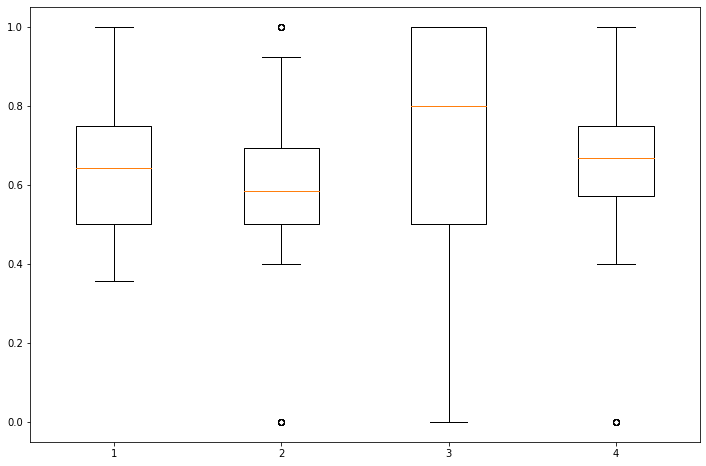

In [16]:
all_results = np.array(all_results)

plt.figure(figsize=(12,8))
plt.boxplot(all_results)
plt.show()

<Figure size 432x288 with 0 Axes>

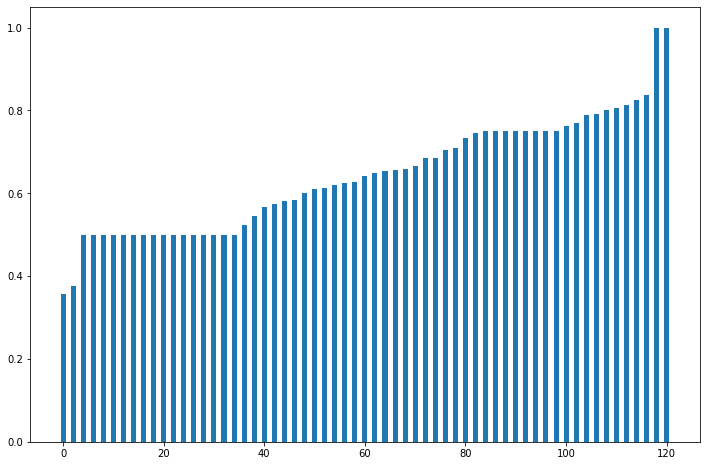

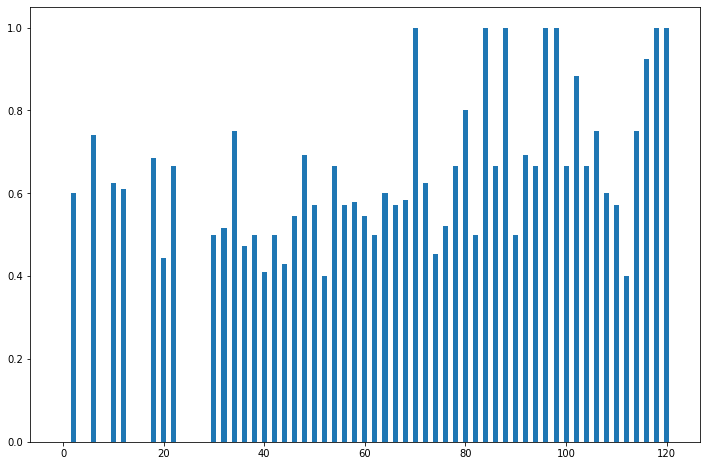

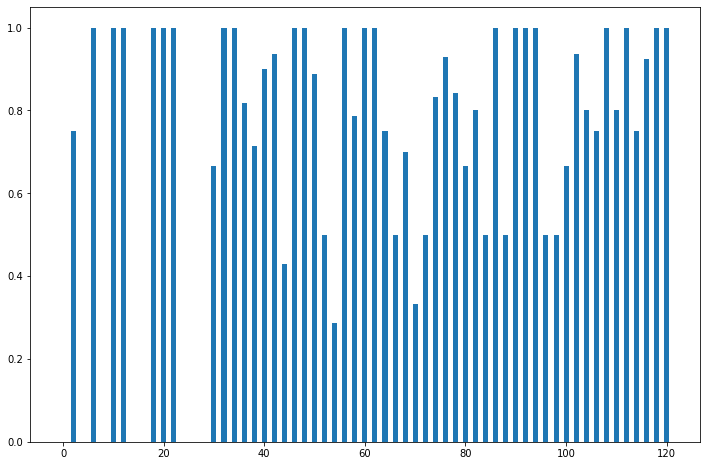

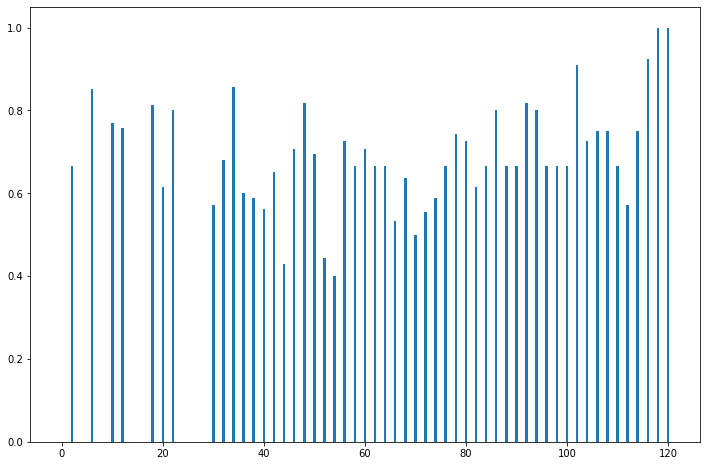

In [17]:
all_results = all_results[all_results[:,0].argsort()]
plt.figure()
roc = all_results[:,0]
precision = all_results[:,1]
recall = all_results[:,2]
f1 = all_results[:,3]
x = np.array([i*2 for i in range(len(roc))])
plt.figure(figsize=(12,8))
plt.bar(x,roc,1)
plt.show()
plt.figure(figsize=(12,8))
plt.bar(x,precision,1)
plt.show()
plt.figure(figsize=(12,8))
plt.bar(x,recall,1)
plt.show()
plt.figure(figsize=(12,8))
plt.bar(x,f1,.5)
plt.show()
# plt.show()

In [62]:
np.median(all_results,axis=0)

array([0.63888889, 0.57142857, 1.        , 0.66666667])

In [18]:
np.median(all_results,axis=0)

array([0.64285714, 0.58333333, 0.8       , 0.66666667])

In [11]:
len(Xf)

1749132

In [18]:
index = y!=None

In [21]:
X1.shape

(15803, 15)